# Class 23 Warm-up: Multiple Linear Regression

Start by loading the usual modules and defining commonly used functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datascience import *
%matplotlib inline

In [23]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz)) / np.std(xyz)


def correlation(t, label_x, label_y):
    return np.mean(
        standard_units(t.column(label_x)) * standard_units(t.column(label_y))
    )


# Regression
def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r * np.std(t.column(label_y)) / np.std(t.column(label_x))


def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y) * np.mean(
        t.column(label_x)
    )

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

From the textbook:\
The following dataset of house prices and attributes was collected over several years for the city of Ames, Iowa. A description of the dataset appears [online](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). We will focus only a subset of the columns. We will try to predict the sale price column from the other columns.

### Load the data

In [17]:
all_sales = Table.read_table('data/ames.csv')
sales = all_sales.where('Bldg.Type', '1Fam').where('Sale.Condition', 'Normal').select(
    'price', 'X1st.Flr.SF', 'X2nd.Flr.SF', 
    'Total.Bsmt.SF', 'Garage.Area', 
    'Wood.Deck.SF', 'Open.Porch.SF', 'Lot.Area', 
    'Year.Built', 'Yr.Sold')
sales.sort('price')

price,X1st.Flr.SF,X2nd.Flr.SF,Total.Bsmt.SF,Garage.Area,Wood.Deck.SF,Open.Porch.SF,Lot.Area,Year.Built,Yr.Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


### Look at the distribution of house sale prices
This is the quantity we are trying to predict.

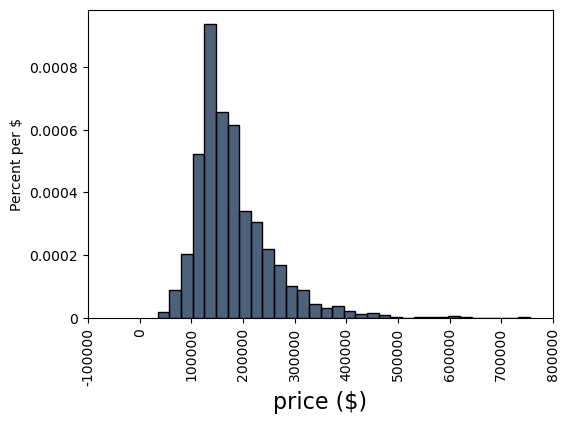

In [19]:
sales.hist('price', bins=32, unit='$')

### Examine linear correlations
Do any of the house features in our table have predictive value? Let's start by looking a price versus the square footage of the first floor.

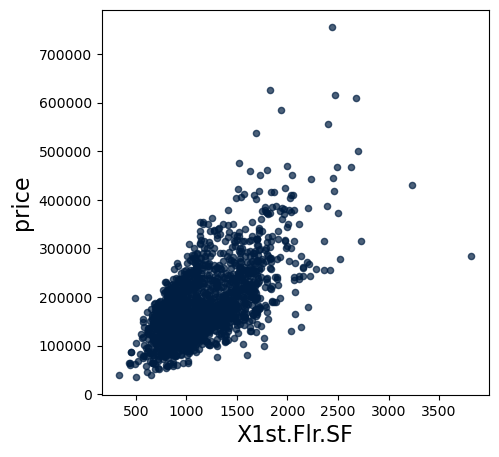

In [48]:
sales.scatter('X1st.Flr.SF', 'price')

In [24]:
correlation(sales, 'price', 'X1st.Flr.SF')

0.64246625410302249

There is a clear positive correlation between the size of the 1st floor and the sale price of the house, but it the prediction is far from perfect. Let's try all of the correlations

In [27]:
for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'price'))

Correlation of price and SalePrice:	 1.0
Correlation of X1st.Flr.SF and SalePrice:	 0.642466254103
Correlation of X2nd.Flr.SF and SalePrice:	 0.35752189428
Correlation of Total.Bsmt.SF and SalePrice:	 0.652978626757
Correlation of Garage.Area and SalePrice:	 0.638594485252
Correlation of Wood.Deck.SF and SalePrice:	 0.352698666195
Correlation of Open.Porch.SF and SalePrice:	 0.336909417026
Correlation of Lot.Area and SalePrice:	 0.290823455116
Correlation of Year.Built and SalePrice:	 0.565164753714
Correlation of Yr.Sold and SalePrice:	 0.0259485790807


### Using more than one feature
None of the correlations is super, but all of the features have some predictive value. Can we combine them? 

In [51]:
both_floors = sales.column(1) + sales.column(2)
two_floors = sales.with_column('Both Floors', both_floors)
two_floors.show(3)

price,X1st.Flr.SF,X2nd.Flr.SF,Total.Bsmt.SF,Garage.Area,Wood.Deck.SF,Open.Porch.SF,Lot.Area,Year.Built,Yr.Sold,Both Floors
215000,1656,0,1080,528,210,62,31770,1960,2010,1656
105000,896,0,882,730,140,0,11622,1961,2010,896
172000,1329,0,1329,312,393,36,14267,1958,2010,1329


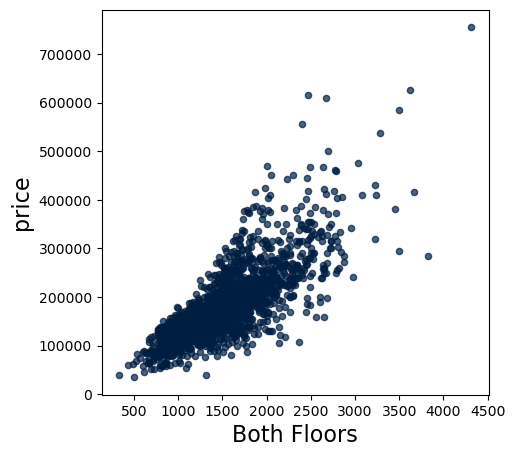

In [52]:
two_floors.scatter('Both Floors', 'price')

In [28]:
correlation(sales.with_column('Both Floors', both_floors), 'price', 'Both Floors')

0.7821920556134877

Using the combined area of the first and second floors yielded a better predictor. You can see that if you compare the two scatter plots as well at the improvement int he correlation.

## Prepare to use them all features
In any type of machine learning, it is common practice to split your dataset into a training data set and test data set. If you use all of your data to train your model, how will you know how well it will work on new data? 

In [53]:
train, test = sales.split(1001)
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1001 training and 1001 test instances.


"The slopes in multiple regression is an array that has one slope value for each attribute in an example. Predicting the sale price involves multiplying each attribute by the slope and summing the result." (textbook section 17.6.2)

Let's try this with just random slopes and calculate the prediction error.

In [54]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('price').row(0)
print('Predicting sale price for:', example_row)

example_slopes = np.random.normal(10, 1, len(example_row))

print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Predicting sale price for: Row(X1st.Flr.SF=1079, X2nd.Flr.SF=874, Total.Bsmt.SF=1580.0, Garage.Area=501.0, Wood.Deck.SF=216, Open.Porch.SF=231, Lot.Area=53107, Year.Built=1992, Yr.Sold=2007)
Using slopes: [ 11.95516067  10.92431354  12.40624033  10.66501066  10.21277506
  10.23099145   9.08640512   9.83114994  10.27531344]
Result: 574719.73835


In [36]:
print('Actual sale price:', test.column('price').item(0))
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 110000
Predicted sale price using random slopes: 133953.840729


"The result is an estimated sale price, which can be compared to the actual sale price to assess whether the slopes provide accurate predictions. Since the example_slopes above were chosen at random, we should not expect them to provide accurate predictions at all."

### Multiple Linear Regression
"The next step in performing multiple regression is to define the least squares objective. We perform the prediction for each row in the training set, and then compute the root mean squared error (RMSE) of the predictions from the actual prices."

In [37]:
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 99356.5669806


"Finally, we use the minimize function to find the slopes with the lowest RMSE. Since the function we want to minimize, rmse_train, takes an array instead of a number, we must pass the array=True argument to minimize. When this argument is used, minimize also requires an initial guess of the slopes so that it knows the dimension of the input array. Finally, to speed up optimization, we indicate that rmse_train is a smooth function using the smooth=True attribute. Computation of the best slopes may take several minutes."

In [55]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

The best slopes for the training set:


X1st.Flr.SF,X2nd.Flr.SF,Total.Bsmt.SF,Garage.Area,Wood.Deck.SF,Open.Porch.SF,Lot.Area,Year.Built,Yr.Sold
70.8707,73.9687,51.2611,51.5419,44.1397,19.5132,0.579462,541.725,-538.927


RMSE of all training examples using the best slopes: 30848.4035528


### Interpretation of Results
"Let’s interpret these results. The best slopes give us a method for estimating the price of a house from its attributes. A square foot of area on the first floor is worth about \\$71 (the first slope), while one on the second floor is worth about \$74 (the second slope). The final negative value describes the market: prices in later years were lower on average.

The RMSE of around \\$30,000 means that our best linear prediction of the sale price based on all of the attributes is off by around \\$30,000 on the training set, on average. We find a similar error when predicting prices on the test set, which indicates that our prediction method will generalize to other samples from the same population."

### Testing the model
Let's test our model on the test data set. REMEMBER: These data were not used to train the model.

In [39]:
test_prices = test.column(0)
test_attributes = test.drop(0)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 31384.8695931


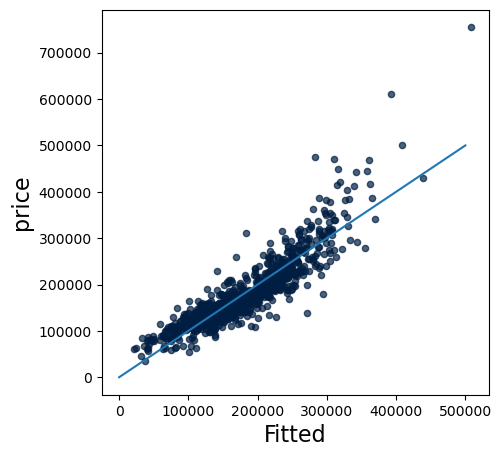

In [41]:
def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plt.plot([0, 5e5], [0, 5e5]);

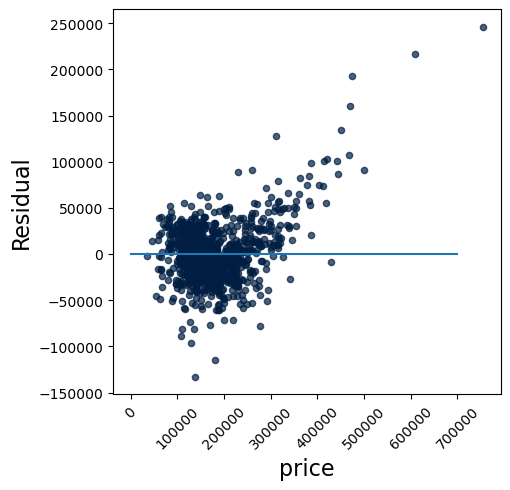

In [46]:
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plt.plot([0, 7e5], [0, 0])
plt.xticks(rotation=45);

### Examining the Residuals
A residual plot for multiple regression typically compares the errors (residuals) to the actual values of the predicted variable. We see in the residual plot below that we have systematically underestimated the value of expensive houses, shown by the many positive residual values on the right side of the graph.